# MindSpore深度学习之手势识别

深度学习技术的发展极大的促进了生产力的提升，智能家务、智能办公等技术景象都在这一轮的技术发展浪潮中成为可能。这其中，手势识别作为一种全新的人机交互模式，在多种场景中都有应用，具有极其重要的作用。本实验探究如何将深度学习技术应用到手势识别之中。本实验的主要内容包含：

- [1] 编写**SE-Conv模型**(SENet+CNN)并进行训练与测试，并将SE-Conv各层次提取的特征**可视化**并进行分析。
- [2] 使用**ResNet18封装模型**进行训练与测试。
- [3] 编写、修改**ViT模型**并进行训练与测试，对比ViT与CNN，**分析**ViT在本任务中效果不佳的原因并提出验证方式。
- [4] 使用HUAWEI MATE30设备**采集**手势数据，设计采集数据**预处理**，并使用上述训练得到的模型进行**模型推理预测**。
- [5] 针对**模型推理效果、模型终端部署、模型应用前景**展开讨论。
- [6] 将模型运用于**另一个手势分类任务**(4-handgesture_mini)，解决模型**不收敛**问题，对比不同**超参数**对模型的影响，对比模型效果。**这部分主要在(附录：实验日志)中展示**。

本实验的目录如下：

- [一] 数据处理与准备：(1)数据集描述 -> (2)数据预处理 -> (3)处理结果可视化
- [二] SE-Conv网络：(1)SENet简介 -> (2)SE-Conv实现 -> (3)SE-Conv训练 -> (4)SE-Conv测试 -> (5)SE-Conv特征可视化
- [三] ResNet18网络：(1)ResNet18简介 -> (2)ResNet18实现与训练 -> (3)ResNet18测试
- [四] Vision Tramsformer网络：(1)ViT简介 -> (2)ViT实现 -> (3)ViT训练与测试 -> (4)ViT效果分析与解释
- [五] 模型推理与应用：(1)数据采集 -> (2)采集数据预处理 -> (3)模型推理
- [六] 拓展讨论：(1)模型推理的影响因素 -> (2)模型的终端部署 -> (3)手势识别的应用展望
- [七] 附录：(1)本文作者 -> (2)实验日志 -> (3)参考文献

开始实验之前，请确保本地已经安装了Python环境并安装了MindSpore Vision套件。

In [1]:
import os
import numpy as np
from PIL import Image
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import requests
from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor
from mindvision.engine.loss import CrossEntropySmooth
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as transforms
import mindspore as ms
from mindspore import Model
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor
from typing import Optional
from mindspore.common.initializer import Normal
from mindvision.classification.models import resnet18
ms.set_seed(1234)

## 一. 数据准备与处理

### (1) 数据集描述

本实验使用Kaggle上的 Hand Gesture Recognition Database 作为数据集(下载地址:https://www.kaggle.com/datasets/gti-upm/leapgestrecog)。

本实验的原数据较大(2GiB)，其中包含十组采样数据，每组中包含十种手势动作的图片。为了实验的方便，我们使用随机采样的方式将数据集适当缩小。具体而言，对于原数据，我们随机采样7%的数据作为训练集，1.5%的数据作为验证集，1.5%的数据作为测试集，并额外加入推理图片，从而构成了本实验使用的handgesture_datasets_mini数据集(180MiB)。

在handgesture_datasets_mini数据集中，包含1400张训练数据与300张验证/测试数据，以及5张推理数据。请将本实验文档与handgesture_datasets_mini数据集放置于同一文件夹下。数据集目录如下：

In [2]:
# handgesture_datasets_mini
#     └── train
#          ├── 01_palm
#          ├── ......
#          └── 10_down
#                 ├── ......
#                 └── xxx.png
#     └── val
#     └── test
#     └── inf
#          ├── origin
#          ├── nobg
#          └── input

数据采样代码如下(请先下载数据集再运行)：

In [5]:
typ = ['train', 'val', 'test']
cl = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok',\
      '08_palm_moved', '09_c', '10_down']
file_base = 'handgesture_datasets_mini'
if not os.path.exists(file_base):
    os.makedirs('handgesture_datasets')
for t in typ:
    filename_1 = file_base+'\\'+t
    if not os.path.exists(filename_1):
        os.makedirs(filename_1)
    for j in cl:
        filename = filename_1+'\\'+j
        if not os.path.exists(filename):
            os.makedirs(filename)
ID_train = 0
ID_dev = 0
ID_test = 0
file_base_org = 'leapGestRecog'
for person_id in range(10):
    filename_1 = file_base_org+'\\0'+str(person_id)
    for g in cl:
        filename_2 = filename_1+'\\'+g
        list_file = os.listdir(filename_2)
        n = len(list_file)
        n_train = int(n*0.07)
        n_dev = int(n*0.015)
        n_test = n_dev
        list_train = random.sample(list_file, n_train)
        for itm in list_train:
            list_file.remove(itm)
        list_dev = random.sample(list_file, n_dev)
        for itm in list_dev:
            list_file.remove(itm)
            list_test = list_file
        for x in list_train:
            file_dir = 'handgesture_datasets\\train\\'+g+'\\'+str(ID_train)+'.png'
            ID_train = ID_train+1
            shutil.copy(filename_2+'\\'+x, file_dir)
        for x in list_dev:
            file_dir = 'handgesture_datasets\\dev\\'+g+'\\'+str(ID_dev)+'.png'
            ID_dev = ID_dev+1
            shutil.copy(filename_2+'\\'+x, file_dir)
        for x in list_test:
            file_dir = 'handgesture_datasets\\test\\'+g+'\\'+str(ID_test)+'.png'
            ID_test = ID_test+1
            shutil.copy(filename_2+'\\'+x, file_dir)

### (2) 数据预处理

在将数据图片输入模型之前，本实验首先对其进行预处理。

具体而言，对于一张图片，首先根据超参数image_size将图片resize为K×K的大小，K=int(image_size×1.05)，然后中心裁剪成image_size大小。为了处理左右手的情况，本例将图片以50%的概率左右反转。最后，本例将图片的RGB三通道值标准化。

上述数据预处理过程使用mindvision中的c_transform模块实现。

In [6]:
class_index = {"01_palm": 0, "02_l": 1, "03_fist":2, "04_fist_moved":3,\
               "05_thumb":4, "06_index":5, "07_ok":6, "08_palm_moved":7, "09_c":8, "10_down":9}
def create_dataset(path, batch_size=10, train=True, image_size=224, class_indexing=None):
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=1, class_indexing=class_index)
    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            transforms.Decode(),
            transforms.Resize(int(image_size*1.05)),
            transforms.CenterCrop(image_size),
            transforms.RandomHorizontalFlip(prob=0.5),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    else:
        trans = [
            transforms.Decode(),
            transforms.Resize(int(image_size*1.05)),
            transforms.CenterCrop(image_size),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    dataset = dataset.map(operations=trans, input_columns="image")
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

### (3) 数据处理可视化

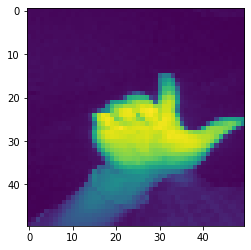

In [7]:
train_path = "handgesture_datasets_mini\\train"
dataset_train = create_dataset(train_path, batch_size=16,\
                               train=True, image_size=50, class_indexing=class_index)
dic = dataset_train.create_dict_iterator(1)
pic = next(dic)['image'][0][0]
pic = (pic-pic.min())/(pic.max()-pic.min())*255
pic = pic.asnumpy()
plt.imshow(pic)

## 二. SE-Conv网络

SENet是Squeeze-and-Excitation Networks的简称，拿到了ImageNet2017分类比赛冠军，其效果得到了认可。SE模块思想简单，易于实现，并且很容易可以加载到现有的网络模型框架中。与传统的注意力机制模型相比，SENet主要是学习了channel之间的相关性，筛选出了针对通道的注意力。

本实验的第一个模型将SENet加载到一个简单的CNN网络(命名为SE-Conv网络)，并在测试集上取得了96%的准确率。为了进一步理解SENet的学习内容，我们将不同层次的提取特征进行了可视化输出。

### (1) SENet 简介

![](src/pic/senet.jpg)

对于卷积操作，很大一部分工作是提高感受野，即空间上融合更多特征，或者是提取多尺度空间信息，如Inception网络的多分支结构。对于channel维度的特征融合，卷积操作基本上默认对输入特征图的所有channel进行融合。而SENet网络的创新点在于关注channel之间的关系，希望模型可以自动学习到不同channel特征的重要程度。为此，SENet提出了SE模块，如上图所示。

具体而言，首先通过n×n的卷积网络进行全局池化，从而将一个channel上整个空间特征编码为一个全局特征。然后，通道特征通过bottleneck结构的两个全连接层，其中第一个FC层起到降维的作用，降维系数为se_ratio是个超参数。本实验中，采用Tanh函数激活。最后的FC层恢复原始的维度。

### (2) SE-Conv实现

![](src/pic/se-conv.jpg)

本实验的第一个模型选择将SENet结构加载到一个简单卷积网络上，从而形成SE-Conv模型。具体而言，Se-Conv包含三个卷积层、一个池化层与两个全连接层，其中SE模块放置在第一、二个卷积层中间，用于使上游16个卷积提取特征通道间进行交互。SE-Conv的具体实现使用MindSpore进行，具体代码如下所示：

SENet模块：

In [8]:
# in_channels是输入卷积特征的通道数，in_w是输入特征的宽度(默认shape为正方形)
class SENet_Enhence(nn.Cell):
    def __init__(self, in_channels, in_w, se_ratio=2):
        super(SENet_Enhence, self).__init__()
        self.conv_global = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=in_w, pad_mode='valid')
        self.drop = nn.Dropout(0.1)
        self.se_d1 = nn.Dense(in_channels=in_channels, out_channels=in_channels//se_ratio)
        self.tanh = nn.Tanh()
        self.se_d2 = nn.Dense(in_channels=in_channels//se_ratio, out_channels=in_channels)
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        w = self.conv_global(x) # (b,c,w,h) --> (b,c,1,1)
        w = w.squeeze(-1)
        w = w.squeeze(-1)
        w = self.drop(w)
        w = self.se_d2(self.tanh(self.se_d1(w)))
        w = self.sigmoid(w)
        w = w.expand_dims(-1)
        w = w.expand_dims(-1)
        x = x*w
        return x

SE-Conv模型：

In [9]:
# image_size即数据预处理后的图片大小，input_channels为输入通道数，out_n即类别总数
class ConvNet(nn.Cell):
    def __init__(self, image_size: int = 224, input_channels: int = 3, out_n: int = 4) -> None:
        super(ConvNet, self).__init__()
        # b,c,w,h
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, pad_mode='same')
        self.se = SENet_Enhence(in_channels=16, in_w=image_size, se_ratio=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, pad_mode='same')
        self.drop = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, pad_mode='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dense = nn.Dense(10000, 768)
        self.relu = nn.Tanh()
        self.dense2 = nn.Dense(768, out_n)
        self.fl = ops.Flatten()
        self.sof = ops.Softmax()

    def construct(self, x):
        x = self.conv1(x)
        x = self.se(x)
        x = self.conv2(x)
        x = self.pool(self.conv3(self.drop(x)))
        x = self.fl(x)
        x = self.relu(self.dense(x))
        x = self.dense2(x)
        x = self.sof(x)
        return x

### (3) SE-Conv模型的训练

经过调试后，SE-Net的训练选择Adam优化器，其中学习率设置为0.0002，动量设置为0.05。输入数据方面，image_size设置为50(50×50)，虽然本例的训练数据接近黑白图片，但本例仍保持输入通道为3。最后，在损失函数上，本例选择mindvision模块提供的CrossEntropySmooth，并设置smooth_factor为0.05。

具体实现上，本例使用MindSpore提供的Model封装模块进行训练，使用准确率Accuracy作为验证标准，并使用mindvision提供的Monitor模块进行验证与保存。

In [10]:
# SENet-Conv 训练 参数设置
train_path = "handgesture_datasets_mini\\train"
dataset_train = create_dataset(train_path, batch_size=16, train=True, image_size=50, class_indexing=class_index)
val_path = "handgesture_datasets_mini\\val"
dataset_val = create_dataset(val_path, batch_size=8, train=False, image_size=50, class_indexing=class_index)

epoch_size = 120
momentum = 0.05
step_size = dataset_train.get_dataset_size()
num_classes = 10
lr = 0.0002

se_conv = ConvNet(image_size=50, input_channels=3, out_n=num_classes)
network_opt = nn.Adam(se_conv.trainable_params(), lr, momentum)
network_loss = CrossEntropySmooth(reduction="mean", smooth_factor=0.05, classes_num=num_classes)

运行下面的代码开始SE-Conv训练(共120个Epoch)：

In [11]:
metrics = {'Accuracy':nn.Accuracy()}
train_model = ms .Model(se_conv, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)
train_model.train(epoch_size, dataset_train,\
                  callbacks=[ValAccMonitor(train_model, dataset_val, epoch_size, best_ckpt_name='best_se_conv_hg10.ckpt'), TimeMonitor()])

也可以直接运行下面的代码加载训练结果：

In [12]:
param_dict = ms.load_checkpoint("model_result\\best_se_conv_hg10.ckpt")
ms.load_param_into_net(se_conv, param_dict)
print("load pretrain SE-Conv")

load pretrain SE-Conv


### (4) SE-Conv结果测试

将模型运用到测试集上，即可得到测试结果。可以发现，训练得到的模型在测试集上取得了约96%的准确率。

加载测试集：

In [13]:
test_path = "handgesture_datasets_mini\\test"
dataset_test = create_dataset(test_path, batch_size=1,\
                              train=False, image_size=50, class_indexing=class_index)

模型测试：

In [14]:
eval_metrics = {'Top_1_Accuracy': nn.Top1CategoricalAccuracy()}
model = ms.Model(se_conv, network_loss, metrics=eval_metrics)
result = model.eval(dataset_test)
print(result)

{'Top_1_Accuracy': 0.9666666666666667}


可以看到，SE-Conv在测试集上获得了96.6%的正确率。

### (5) SE-Conv特征可视化

为了更好的理解SE-Conv的工作情况，本例将SE-Conv各个层次提取的特征可视化。在卷积神经网络中，不同的channel能够关注到不同的具体特征，因此，输出SE-Conv提取的特征即对网络不同层次提取的特征图进行可视化。

为了实现本例后面的各种功能，首先实现三个数据处理函数，具体含义如下：

In [15]:
# 输入图像(numpy)和超参数image_size，输出进行过数据预处理后的结果
def trans_pic(x, image_size):
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    tr1 = transforms.Resize(int(image_size*1.05))
    x = tr1(x)
    tr2 = transforms.CenterCrop(image_size)
    x = tr2(x)
    tr3 = transforms.Normalize(mean=mean, std=std)
    x = tr3(x)
    tr4 = transforms.HWC2CHW()
    x = tr4(x)
    return x

# 输入图片文件地址filename，输出经过预处理后的结果，并转化可以用plt.imshow显示的格式
def get_print_pic(filename, image_size):
    img = np.array(Image.open(filename))
    if img.ndim == 2:
        img = img.reshape((img.shape[0], img.shape[1], 1))
        img = np.concatenate([img, img, img], axis=2)
        img_x = trans_pic(img, image_size=image_size)
    img_x = img_x.transpose((1, 2, 0))
    return img_x

# 输入图片文件地址filename，输出经过预处理后的结果，并转化可以输入训练模型的格式
def get_input_pic(filename, image_size):
    img = np.array(Image.open(filename))
    if img.ndim == 2:
        img = img.reshape((img.shape[0], img.shape[1], 1))
        img = np.concatenate([img, img, img], axis=2)
    img_x = trans_pic(img, image_size=image_size)
    img_x = ms.Tensor(img_x).reshape([1, 3, 50, 50])
    return img_x

随后使用上述函数即可进行特征可视化：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


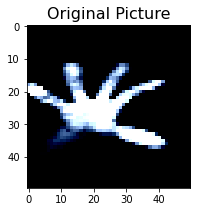

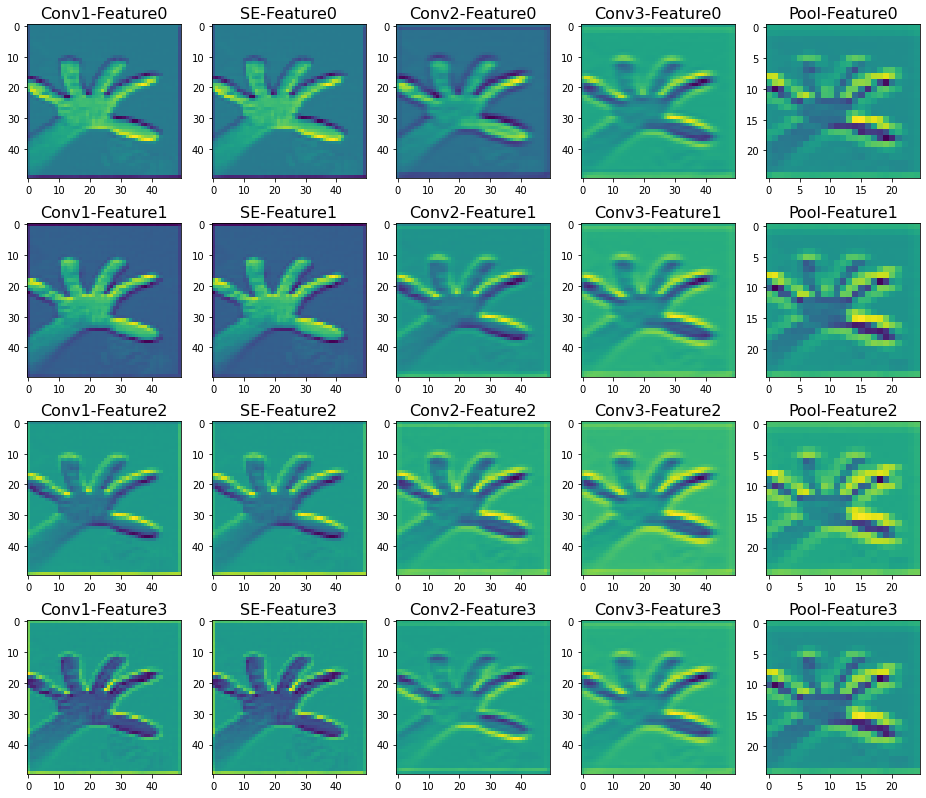

In [16]:
show_cls = '10_down'
plt.figure(figsize=(3, 3))
filename = test_path+'\\'+show_cls+'\\'+os.listdir(test_path+'\\'+show_cls)[10]
img_in = get_print_pic(filename, image_size=50)
plt.title(f"Original Picture", fontsize=16)
plt.imshow(img_in)
plt.figure(figsize=(16, 14))
input = get_input_pic(filename, image_size=50)
feature_graph1 = se_conv.se(se_conv.conv1(input))
feature_graph_se = se_conv.se(se_conv.conv1(input))
feature_graph2 = se_conv.conv2(se_conv.se(se_conv.conv1(input)))
feature_graph3 = se_conv.conv3(se_conv.conv2(se_conv.se(se_conv.conv1(input))))
feature_graph_pool = se_conv.pool(se_conv.conv3(se_conv.conv2(se_conv.se(se_conv.conv1(input)))))
feature_graph_list = [feature_graph1, feature_graph_se, feature_graph2, feature_graph3, feature_graph_pool]
feature_name = ['Conv1', 'SE', 'Conv2', 'Conv3', 'Pool']

def show_feature_map(i):
    for j in range(4):
        p_ID = i*4+j
        for k in range(5):
            plt.subplot(4, 5, 5*j+k+1)
            pic = feature_graph_list[k][0, p_ID, :, :].asnumpy()
            pic = (pic-pic.min())/(pic.max()-pic.min())*255
            pic = pic.astype(np.int32)
            plt.title(f"{feature_name[k]}-Feature{p_ID}", fontsize=16)
            plt.imshow(pic)

show_feature_map(0)

在上述特征图中，亮部即网络层关注部分。可以发现，不同的channel会关注不同的局部信息。如在Conv1-Feature中，第1个通道关注宏观的手掌，而第二个通道则重点关注大拇指、食指和小拇指，第三个通道关注手的边缘，而第四个通道则重点关注手的轮廓线。同时可以发现，不同通道中越高层次的特征图越趋于相同，这是由于高层次的特征由低层次特征提取出来，更为重要与精炼，因此高层次通道都会优先去关注那些最为重要的特征。例如在上图中，基本上所有通道在Pool阶段时，相比于手心与手掌的部分，都更为关注手的边缘与轮廓线。

## 三. ResNet18网络

### (1) ResNet18简介

本例的第二个模型采用图像处理领域中颇负盛名的Resnet系列网络。ResNet的结构可以极快的加速神经网络的训练，并对模型的准确率产生较大的提升。本例采用的是体量最小的Resnet18卷积网络。

我们知道深层网络存在着梯度消失或者爆炸的问题，这使得深度学习模型很难训练。而Resnet的最大创新点则是使用Res残差结构，使得深度爆炸问题得到了极大的缓解。

![](src/pic/resnet_in.jpg)

Resnet18首先经过一个7×7卷积层和3×3 MaxPooling层，然后是四个“Res模块”，每个模块由两个Build Block组成，而每个Build Block又由两个卷积层组成，其中卷积层由残差结构与bottleneck结构构成，具体可见论文《Deep Residual Learning for Image Recognition》。特征最后则是通过average pool、全连接层。由于Pooling层不需要参数学习，故去除Pooling层，整个resnet18网络由18层组成。

![](src/pic/resnet_info2.jpg)

### (2) ResNet18实现与训练

MindSpore Vision是一个开源的基于MindSpore框架的计算机视觉研究工具箱，工具所涉及的任务主要包括分类、检测(开发中)、视频(开发中)和3D(开发中)。MindSpore Vision旨在通过提供易用的接口来帮助用户复现现有的经典模型并开发自己的新模型。MindVision工具箱中包含大量预先写好的视觉模型，这其中就包括了ResNet18。因此，本实验选择直接使用MindVision提供的resnet18模型，并在此基础上进行训练。

经过调试后，ResNet的训练选择Adam优化器，其中学习率设置为0.0002，不设置动量。输入数据方面，image_size设置为50(50×50)，虽然本例的训练数据接近黑白图片，但本例仍保持输入通道为3。最后，在损失函数上，本例选择mindspore.nn模块提供的SoftmaxCrossEntropyWithLogits损失函数。

$ l(x_{i},c)=-log(\frac{exp(x_{i}[c])}{\sum_{j}(x_{i}[j])})=-x_{i}[c]+log(\sum_j exp(x_{i}[j])) $

在训练了30个epoch左右，模型在验证集上的准确率达到了99%左右。

In [17]:
## ResNet训练参数设置
train_path = "./handgesture_datasets_mini/train"
dataset_train = create_dataset(train_path, batch_size=32, train=True, image_size=50)
val_path = "./handgesture_datasets_mini/val"
dataset_val = create_dataset(val_path, batch_size=32, train=False, image_size=50)

resnet18 = resnet18(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Adam(resnet18.trainable_params(), learning_rate=0.0002)
metrics = {"Accuracy": nn.Accuracy()}
model = Model(resnet18, loss_fn=net_loss, optimizer=net_opt, metrics=metrics)
num_epochs = 120

运行下面的代码开始ResNet的训练：

In [18]:
model.train(num_epochs, dataset_train,\
            callbacks=[ValAccMonitor(resnet18, dataset_val, num_epochs, epoch_size, best_ckpt_name='best_resnet18_imagesize=50.ckpt'), TimeMonitor()])

也可以运行下面的代码直接加载预训练好的模型：

In [19]:
param_dict = ms.load_checkpoint("model_result\\best_resnet18_imagesize=50.ckpt")
ms.load_param_into_net(resnet18, param_dict)
print("load pretrain ResNet18")

load pretrain ResNet18


### (3) ResNet18结果测试

加载测试数据：

In [20]:
test_path = "handgesture_datasets_mini\\test"
dataset_test = create_dataset(test_path, batch_size=1, train=False, image_size=50, class_indexing=class_index)

模型测试：

In [21]:
eval_metrics = {'Top_1_Accuracy': nn.Top1CategoricalAccuracy()}
model = ms.Model(resnet18, network_loss, metrics=eval_metrics)
result = model.eval(dataset_test)
print(result)

{'Top_1_Accuracy': 0.9966666666666667}


可以看到，ResNet18在测试集上获得了99.6%的正确率。

## 四. Vision Transformer网络(ViT)

### (1) ViT简介

![](src/pic/vit.png)

近些年，随着基于自注意结构（Self-Attention）的模型的发展，特别是Transformer模型的提出，极大地促进了自然语言处理模型的发展。由于Transformers的计算效率和可扩展性，它已经能够训练具有超过100B参数的空前规模的模型。

ViT则是自然语言处理和计算机视觉两个领域的融合结晶。在不依赖卷积操作的情况下，依然可以在图像分类任务上达到很好的效果，通过注意力机制提取全局空间结构信息，依旧能在大多数视觉任务上获得不错的结果。

### (2) ViT实现

详细的实现过程可以见MindSpore官网的ViT教程：
https://www.mindspore.cn/tutorials/application/zh-CN/master/cv/vit.html

本例的ViT代码对官方教程的代码进行了修正。为了适应本实验的任务，本例还在此基础上进行了一定的修改。

完整的ViT代码如下：

In [22]:
class Attention(nn.Cell):
    def __init__(self, dim: int, num_heads: int = 8, keep_prob: float = 1.0, attention_keep_prob: float = 1.0):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = ms.Tensor(head_dim ** -0.5)
        self.qkv = nn.Dense(dim, dim * 3)
        self.attn_drop = nn.Dropout(attention_keep_prob)
        self.out = nn.Dense(dim, dim)
        self.out_drop = nn.Dropout(keep_prob)
        self.mul = ops.Mul()
        self.reshape = ops.Reshape()
        self.transpose = ops.Transpose()
        self.unstack = ops.Unstack(axis=0)
        self.attn_matmul_v = ops.BatchMatMul()
        self.q_matmul_k = ops.BatchMatMul(transpose_b=True)
        self.softmax = nn.Softmax(axis=-1)

    def construct(self, x):
        b, n, c = x.shape
        qkv = self.qkv(x)
        qkv = self.reshape(qkv, (b, n, 3, self.num_heads, c // self.num_heads))  #(b,n,3,n_head,d_head)
        qkv = self.transpose(qkv, (2, 0, 3, 1, 4))        # (3,b,n_head,n,d_head)
        q, k, v = self.unstack(qkv)                       # (b,n_head,n,d_head)
        attn = self.q_matmul_k(q, k)                      # (b,n_head,n,n)
        attn = self.attn_drop(self.softmax(self.mul(attn, self.scale)))
        out = self.attn_matmul_v(attn, v)                 # (b,n_head,n,d_head)
        out = self.transpose(out, (0, 2, 1, 3))           # (b,n,n_head,d_head)
        out = self.out_drop(self.out(self.reshape(out, (b, n, c))))
        return out

class FeedForward(nn.Cell):
    def __init__(self, in_feature, hidden_feature, activation, keep_prob):
        super(FeedForward, self).__init__()
        self.feed = nn.Dense(in_feature, hidden_feature)
        self.activation = activation()
        self.drop = nn.Dropout(keep_prob)

    def construct(self, x):
        x = self.feed(x)
        x = self.activation(x)
        x = self.drop(x)
        return x

class ResidualCell(nn.Cell):
    def __init__(self, net):
        super(ResidualCell, self).__init__()
        self.net = net

    def construct(self, x):
        x = self.net(x)+x
        return x

class TransformerEncoder(nn.Cell):
    def __init__(self, dim: int, num_layers: int, num_heads: int, mlp_dim: int, keep_prob: float = 1.,\
                 attention_keep_prob: float = 1.0, drop_path_keep_prob: float = 1.0, activation: nn.Cell = nn.GELU,\
                 norm: nn.Cell = nn.LayerNorm):
        super(TransformerEncoder, self).__init__()
        layers = []
        for _ in range(num_layers):
            normalization1 = norm((dim, ))
            normalization2 = norm((dim, ))
            attention = Attention(dim=dim, num_heads=num_heads, keep_prob=keep_prob, attention_keep_prob=attention_keep_prob)
            feedforward = FeedForward(in_feature=dim, hidden_feature=mlp_dim, activation=activation, keep_prob=keep_prob)
            layers.append(\
                nn.SequentialCell([\
                    ResidualCell(nn.SequentialCell([normalization1, attention])),\
                    ResidualCell(nn.SequentialCell([normalization2, feedforward]))\
                ])\
            )
        self.layers = nn.SequentialCell(layers)

    def construct(self, x):
        return self.layers(x)

class PatchEmbedding(nn.Cell):
    def __init__(self, image_size: int = 224, patch_size: int = 16, embed_dim: int = 768, input_channels: int = 3):
        super(PatchEmbedding, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.conv = nn.Conv2d(input_channels, embed_dim, kernel_size=patch_size, stride=patch_size, has_bias=True)
        self.reshape = ops.Reshape()
        self.transpose = ops.Transpose()

    def construct(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = self.reshape(x, (b, c, h * w))
        x = self.transpose(x, (0, 2, 1))
        return x

class VIT(nn.Cell):
    def __init__(self, image_size: int = 224, input_channels: int = 3, patch_size: int = 16, embed_dim: int = 768,\
                 num_layers: int = 12, num_heads: int = 12, mlp_dim: int = 3072, keep_prob: float = 1.0,\
                 attention_keep_prob: float = 1.0, drop_path_keep_prob: float = 1.0, activation: nn.Cell = nn.GELU,\
                 norm: Optional[nn.Cell] = nn.LayerNorm, pool: str = 'cls') -> None:
        super(VIT, self).__init__()

        self.patch_embedding = PatchEmbedding(image_size=image_size, patch_size=patch_size,\
                                              embed_dim=embed_dim, input_channels=input_channels)
        num_patches = self.patch_embedding.num_patches
        self.cls_token = ms.Parameter(Tensor(init=Normal(sigma=1.0), shape=(1, 1, embed_dim), dtype=ms.float32),\
                                    name='cls_token', requires_grad=True)
        self.pos_embedding = ms.Parameter(Tensor(init=Normal(sigma=1.0), shape=(1, num_patches + 1, embed_dim), dtype=ms.float32),\
                                        name='pos_embedding', requires_grad=True)
        self.concat = ops.Concat(axis=1)
        self.pool = pool
        self.pos_dropout = nn.Dropout(keep_prob)
        self.norm = norm((embed_dim, ))
        self.tile = ops.Tile()
        self.transformer = TransformerEncoder(dim=embed_dim, num_layers=num_layers, num_heads=num_heads, mlp_dim=mlp_dim,\
                                              keep_prob=keep_prob, attention_keep_prob=attention_keep_prob,\
                                              drop_path_keep_prob=drop_path_keep_prob,\
                                              activation=activation, norm=norm)
    def construct(self, x):
        x = self.patch_embedding(x)
        cls_tokens = self.tile(self.cls_token, (x.shape[0], 1, 1))  #(b,n,d)
        x = self.concat((cls_tokens, x))
        x += self.pos_embedding
        x = self.pos_dropout(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]
        return x

class VIT_Model(nn.Cell):
    def __init__(self, cls_num=10, image_size: int = 224, input_channels: int = 3, patch_size: int = 16, embed_dim: int = 768,\
                 num_layers: int = 12, num_heads: int = 12, mlp_dim: int = 3072, keep_prob: float = 1.0,\
                 attention_keep_prob: float = 1.0, drop_path_keep_prob: float = 1.0, activation: nn.Cell = nn.GELU,\
                 norm: Optional[nn.Cell] = nn.LayerNorm, pool: str = 'cls'):
        super(VIT_Model, self).__init__()
        self.vit = VIT(image_size=image_size, input_channels=input_channels, patch_size=patch_size, embed_dim=embed_dim, num_layers=num_layers,\
                    num_heads=num_heads, mlp_dim=mlp_dim, keep_prob=keep_prob, attention_keep_prob=attention_keep_prob,\
                    drop_path_keep_prob=drop_path_keep_prob)
        self.classifier = nn.Dense(mlp_dim, cls_num)

    def construct(self, x):         # (b,n,c,w,h)
        x = self.vit(x)
        x = self.classifier(x)
        return x

### (3) ViT模型训练与测试

ViT模型训练的可调整内容大致包括：momentum、lr、image_size、embed_dim、smooth_factor、num_layers、num_heads。

经过反复调整，ViT模型依旧未能取得较好的效果，一些可能的解释见下文。本实验还将ViT模型应用到了另一个四分类手势识别问题上进行验证(见附件中的实验日志描述)，其效果依旧远不如卷积神经网络。因此，基本可以得出结论：在手势识别问题上，以Transformer为基础的ViT模型不如以CNN为基础的卷积神经网络模型。

介于此，下面的代码仅是一个训练示例，不代表绝对的最优训练参数：

In [23]:
## ViT训练参数设置
train_path = "./handgesture_datasets_mini/train"
dataset_train = create_dataset(train_path, batch_size=16, train=True, image_size=50)
val_path = "./handgesture_datasets_mini/val"
dataset_val = create_dataset(val_path, batch_size=8, train=False, image_size=50)

epoch_size = 80
momentum = 0.05
step_size = dataset_train.get_dataset_size()
num_classes = 10
lr = 0.00002

vit_net = VIT_Model(cls_num=num_classes, image_size=50, input_channels=3, patch_size=5, embed_dim=512,\
                   num_layers=6, num_heads=8, mlp_dim=512, keep_prob=0.2, attention_keep_prob=0.2, drop_path_keep_prob=0.2)

network_opt = nn.Adam(vit_net.trainable_params(), lr, momentum)
network_loss = CrossEntropySmooth(reduction="mean", smooth_factor=0.1, classes_num=num_classes)
metrics = {'Accuracy':nn.Accuracy()}
train_model = ms .Model(vit_net, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

In [24]:
train_model.train(epoch_size, dataset_train, callbacks=[ValAccMonitor(train_model, dataset_val,\
                  epoch_size, best_ckpt_name='best_vit.ckpt'), TimeMonitor()])
param_dict = ms.load_checkpoint("model_result\\best_vit.ckpt")
ms.load_param_into_net(vit_net, param_dict)
print("load pretrain ViT")
test_path = "handgesture_datasets_mini\\test"
dataset_test = create_dataset(test_path, batch_size=1, train=False, image_size=50, class_indexing=class_index)
eval_metrics = {'Top_1_Accuracy': nn.Top1CategoricalAccuracy()}
model = ms.Model(vit_net, network_loss, metrics=eval_metrics)
result = model.eval(dataset_test)
print(result)

load pretrain ViT
{'Top_1_Accuracy': 0.16}


### (4) ViT效果分析与解释

从上述结果可以发现，ViT在handgesture-mini数据集上的表现较为糟糕。作者对训练参数和ViT结构进行了多次调整，得到的结果都较为糟糕。因此，基本上可以得出结论，基础的ViT模型并不适合该任务。

作者尝试对此结果进行分析。可能的原因如下：

第一，训练操作问题，然而作者已经反复调试，因此这种原因的可能性较小。

第二，patch的大小太大，导致学习过程中的信息细粒度太低。

第三，该任务中的图像隐含模式具有特定性质，其模式信息主要集中在局部的轮廓信息，而非全局的空间结构。而Transformer结构更关注全局空间结构，而传统卷积网络则更能提取出局部轮廓信息。作者认为，此原因的可能性较大，而我们对SE-Conv进行提取特征可视化输出的结果也验证了这一点。对于这一原因，一种可能的验证方式是编写Transformer与CNN结合的产物MobileViT并进行测试。若MobileViT的效果介于ViT和CNN之间，则可以证明该猜想正确。

## 五. 模型推理与应用

在进行这一部分实验前，请先将src文件夹中的infer文件夹拷贝到handgesture_datasets_mini文件夹内。

### (1) 数据采集

最后，本例进行模型推理与应用。本例将训练得到的SE-Conv模型应用到直接采集的数据。

我们使用HUAWEI MATE30设备拍摄了5张含背景手势图像：

![](src/pic/org-hand.png)

### (2) 采集数据预处理

首先将模型训练所用数据显示如下：

![](src/pic/train-hand.png)

注意到模型训练所用的数据是高对比度的类黑白图像，其中手部呈现白色，而背景则呈现纯黑色。因此，为了让训练得到的模型可以应用于采集到的数据，必须完成背景去除与黑白转换两个步骤。

对于背景去除工作，Removebg是著名的一键式图像分割软件。由于本例重点关注图像识别而非图像分割，因此我们选择直接采用Removebg软件的Python接口，具体的内容读者可以自行查阅。背景去除的效果如下：

![](src/pic/nobg-hand.png)

背景去除后，图像仅在被识别为手部的区域有像素值(其它位置像素值接近于0)。因此，本例设置像素值阈值thresh，当像素值大于thresh时，将像素点设置为白色，否则设置为黑色。

上述两步的具体执行代码如下：

In [25]:
filename_base = 'handgesture_datasets_mini\\infer'
nobg_file_list = []
file_list = os.listdir(filename_base+'\\origin')
print(file_list)
for f in file_list:
    filename = filename_base+'\\origin\\'+f
    filename_nobg = filename_base+'\\nobg\\'+f[:-4]+'_nobg.jpg'
    filename_input = filename_base+'\\input\\'+f[:-4]+'_input.jpg'
    response = requests.post(\
        'https://www.remove.bg/tools-api',\
        files={'image_file': open(filename, 'rb')},\
        data={'size': 'auto'},\
        headers={'X-Api-Key': 'PBDo7WvQaMNveH9jhimmqTst'},\
    )
    if response.status_code == requests.codes.ok:
        with open(filename_nobg, 'wb') as out:
            out.write(response.content)
    else:
        print("Error:", response.status_code, response.text)
    img_grey = cv2.imread(filename_nobg, cv2.IMREAD_GRAYSCALE)
    thresh = 30
    img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(filename_input, img_binary)

最终的处理效果如下：

![](src/pic/input-hand.png)

### (3) 模型推理

使用刚才预训练好的模型进行预测，得到的结果如下。在当前采集的五张图片中，我们的SE-Conv模型成功预测了四张，唯一错误的一张将ok手势预测成了palm_moved。

In [26]:
def infer(filename, model_inf):
    img_x = get_input_pic(filename, image_size=50)
    out = model_inf(img_x)
    pred = out.argmax(-1)
    return (pred, list(class_index.keys())[pred])

filename_base_inf_input = 'handgesture_datasets_mini\\infer\\input'
file_list = os.listdir(filename_base_inf_input)
for f in file_list:
    filename = filename_base_inf_input+'\\'+f
    pred = infer(filename, se_conv)[1]
    print(f"pred={pred} ; ans={f[:-10]}")

pred=09_c ; ans=inf_c
pred=10_down ; ans=inf_down
pred=02_l ; ans=inf_l
pred=08_palm_moved ; ans=inf_ok
pred=01_palm ; ans=inf_palm


## (六). 拓展讨论

### (1) 模型推理的影响因素

在上述过程中，我们将原采集图片去除背景，并进行黑白处理。但观察原训练数据，不难发现其并非纯黑白图片，而是有一定灰度，并且在手部边缘出出现了明显的颜色渐变。这种差异将导致模型推理能力的下降。一种可能的解决方案是对训练/验证/测试数据也进行黑白预处理，再在此基础上训练新的模型。

更重要的影响因素在于采集数据时的角度。观察训练集/验证集可以发现，对于某一个手势，在数据集中只包含特定角度采集的数据。因此，理论上本实验的模型不支持zero-shot，因此只能学习到特定角度采集到的手势中的模式。毫无疑问，数据采集角度将对模型的静态推理产生巨大的影响。解决这个问题的第一个方式是，在采集手势数据时从特定角度采集，但这在实际操作中毫无疑问是困难的。第二个方式或许更为可行，即将静态推理改为动态推理，即模型对采集的手势视频进行实时预测，并取一段时间内置信度最高的手势作为预测结果。当然，为了实现实时预测，则需要将模型部署到终端设备。

### (2) 模型的终端部署

本例使用的MindSpore架构有配套的MindSpore Lite全生态AI引擎，因此将训练得到的模型(假设其适合部署，这里暂且不讨论模型的量级问题)部署到终端的最大困难主要在于：如何将采集图像的预处理函数部署到终端。这个问题设计更复杂的程序设计问题，以Android系统APP部署为例，通过查看MindSpore仓库可以发现，MindVision APP的数据预处理由Vision仓中的:

android/enginelibrary/src/main/cpp/classification/CustomMindSporeNetnative.cpp

中的PreProcessImageData函数实现。

![](src/pic/ct.png)

因此，想要将本例的模型部署到终端，则首先应当用C语言修改上述代码，然后使用MindSpore Lite将模型部署到APP端。

### (3) 手势识别的应用展望

手势识别的本质是一种全新的人机交互模式，其具有广泛的应用前景，一些例子列举如下。第一，智能家居。手势识别可以使家居物联网的操作互联进一步简化。第二，智能安全。手势识别可以用于对特定安全领域，如当对特定物品(核电站设备、婴幼儿误碰等)进行非法操作时，及时发出警报。第三，智能办公。手势识别将使人机交互效率得到进一步提升，从而提高办公效率。第四，智能教学。手势识别可以广泛运用于手部精细操作的教育与纠正，如幼儿写字、雕刻工艺、乐器弹奏等。第五，智能娱乐。手势识别方式为人机交互提供了全新的视角，必将激发电子娱乐产业的新一波革命......综上所述，手势识别是智能交互领域的风口，具有广阔的应用前景与巨大的商业价值。

## 七. 附录

### (1) 本文作者

本实验项目系2022年华中七校华为昇腾AI训练营第16小组成果

作者为：武汉大学 啊对对队 ycbqwq ; qaz-del ; donghongyuu

### (2) 实验日志

在实验过程中，作者遇到的问题与对应的解决方法在handgesture_log.md中记录，供读者参考。

上述模型的训练参数与详细训练结果也在handgesture_log.md中记录。

### (3) 参考文献

- [1] https://www.kaggle.com/datasets/gti-upm/leapgestrecog
- [2] https://www.remove.bg/tools-api
- [3] Hu J, Shen L, Sun G. Squeeze-and-excitation networks[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2018: 7132-7141.
- [4] He K, Zhang X, Ren S, et al. Deep residual learning for image recognition[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2016: 770-778.
- [5] Dosovitskiy A, Beyer L, Kolesnikov A, et al. An image is worth 16x16 words: Transformers for image recognition at scale[J]. arXiv preprint arXiv:2010.11929, 2020.
- [6] Mehta S, Rastegari M. Mobilevit: light-weight, general-purpose, and mobile-friendly vision transformer[J]. arXiv preprint arXiv:2110.02178, 2021